In [1]:
# KoNLPy 설치
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 47.6 MB/s eta 0:00:00


In [2]:
# KoBERT 파일 설치
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-riov2cx6
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-riov2cx6
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.4 MB/s eta 0:00

In [3]:
# 필요한 라이브러리 불러오기
import sqlite3

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from konlpy.tag import Okt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import gluonnlp as nlp
from kobert import get_pytorch_kobert_model
from kobert import get_tokenizer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from tqdm import tqdm, tqdm_notebook

import pickle

## 데이터 정제

In [2]:
# DB 연결 후 review 테이블을 가져오기
DB_FILENAME = 'projectDB.db'
conn = sqlite3.connect(DB_FILENAME)
cur = conn.cursor()
reviewdata = cur.execute("""SELECT *
FROM review r;
""")

In [3]:
# review 테이블을 데이터프레임으로 가져오기
cols = [col[0] for col in reviewdata.description]
df = pd.DataFrame(data=reviewdata.fetchall(), columns=cols)

In [4]:
# DB 연결 종료
cur.close()
conn.close()

In [8]:
# 데이터 확인
df.head()

,상호명,리뷰어,리뷰날짜,별점,코멘트
0,우유부단,L,2022.08.22,80,NaN
1,우유부단,나,2022.05.11,100,맛있었어요. 우리 아기가 양을 좋아해서 아이스크림 먹으며 양구경을ㅎㅎ
2,우유부단,ㅎ,2022.04.16,60,"우유아이스크림과 밀크쉐이크, 우도땅콩밀크티는 먹을만한데요 아메리카노,라떼, 카카오밀..."
3,우유부단,beaucoupderiz,2022.01.12,40,NaN
4,우유부단,석원,2022.01.11,100,NaN


In [9]:
print(df.shape)
print(df.info())

(39704, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39704 entries, 0 to 39703
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상호명     39704 non-null  object
 1   리뷰어     39047 non-null  object
 2   리뷰날짜    39145 non-null  object
 3   별점      39704 non-null  int64 
 4   코멘트     35441 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
None


In [10]:
# 상호명이 공란인 경우 확인
df[df['상호명']=='']

,상호명,리뷰어,리뷰날짜,별점,코멘트


In [11]:
# 리뷰어가 공란인 경우 확인
df[df['리뷰어']=='']

,상호명,리뷰어,리뷰날짜,별점,코멘트


In [12]:
# 리뷰어 공란 None으로 대체
df['리뷰어'] = df['리뷰어'].replace('', 'None')

In [13]:
# 리뷰날짜가 공란인 경우 확인
df[df['리뷰날짜']=='']

,상호명,리뷰어,리뷰날짜,별점,코멘트


In [14]:
# 리뷰날짜 공란을 NaN으로 대체한 후 결측치 삭제
df['리뷰날짜'] = df['리뷰날짜'].replace('', np.nan)
df = df.dropna(subset = ['리뷰날짜'])

In [15]:
# 리뷰 코멘트가 공란인 경우 확인
df[df['코멘트']=='']

,상호명,리뷰어,리뷰날짜,별점,코멘트


In [16]:
# 리뷰 코멘트 공란을 NaN으로 대체한 후 결측치 삭제
df['코멘트'] = df['코멘트'].replace('', np.nan)
df = df.dropna(subset = ['코멘트'])

<ipython-input-16-5e0ada2361f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['코멘트'] = df['코멘트'].replace('', np.nan)


In [17]:
# 별점 1~5점으로 변경
df['별점'] = df['별점'] / 20

In [18]:
# 상호명, 리뷰어, 리뷰날짜를 조합해 id 생성
df['id'] = df['상호명'] + ';' + df['리뷰어'] + ';' + df['리뷰날짜']

In [19]:
# id, 별점, 코멘트만 남기고 불필요한 컬럼 삭제
df = df.drop(['상호명', '리뷰어', '리뷰날짜'], axis=1)

In [20]:
# 컬럼명 및 순서 정리
df = df[['id', '별점', '코멘트']]
df = df.rename(columns={'별점': 'rating', '코멘트': 'reviews'})

In [21]:
# 정제된 df 확인
print(df.shape)
df.head()

(35441, 3)


,id,rating,reviews
1,우유부단;나;2022.05.11,5.0,맛있었어요. 우리 아기가 양을 좋아해서 아이스크림 먹으며 양구경을ㅎㅎ
2,우유부단;ㅎ;2022.04.16,3.0,"우유아이스크림과 밀크쉐이크, 우도땅콩밀크티는 먹을만한데요 아메리카노,라떼, 카카오밀..."
5,우유부단;BEARDOOR;2022.01.05,3.0,이시돌목장 우유를 좋아해서 밀크티도 기대했는데 조금 아쉬웠네요...그래도 목장 구경...
6,우유부단;타;2021.12.05,1.0,맛은 잘모르겠고 가격이 너무비쌈 그리고 가장 중요한 직원들이 개판임 너무불친절함 항...
7,우유부단;DH. KIM;2021.11.21,2.0,밀크쉐이크. 밀크티 먹기 전에\n별점 볼걸 후회됨.


## EDA

#### Target에 Label 추가

Text(0.5, 1.0, 'Count of ratings')

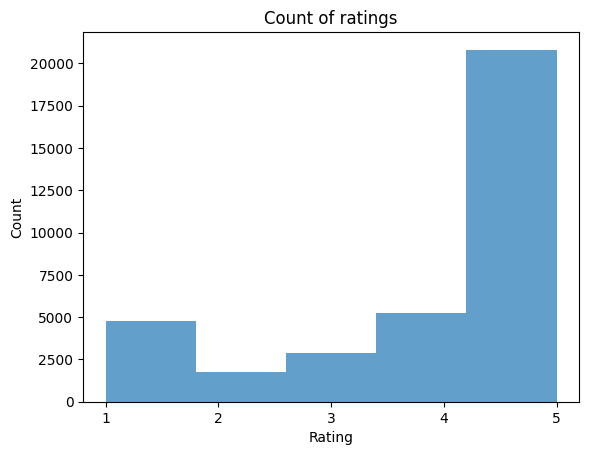

In [22]:
# Rating histogram
plt.hist(df['rating'], bins=5, alpha=0.7)
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of ratings')

In [23]:
# label 추가: 별점1~2 부정(0) / 별점3~4 nan / 별점5 긍정(1)
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 5:
        return 1

df['label'] = df['rating'].apply(lambda x: label_encode(x))

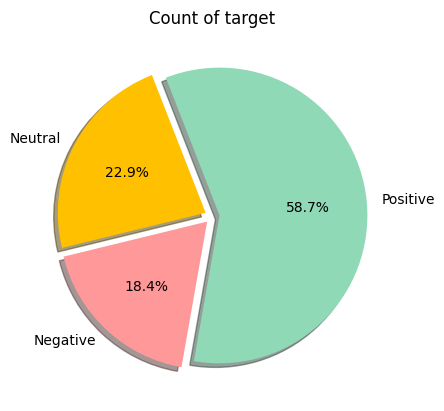

In [24]:
# label piechart
ratio = [len(df[df['label']==0])/len(df), len(df[df['label'].isnull()])/len(df), len(df[df['label']==1])/len(df)]
labels = ['Negative', 'Neutral', 'Positive']
explode = [0.05, 0.05, 0.05]
colors = ['#ff9999', '#ffc000', '#8fd9b6']

plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors)
plt.title('Count of target');

#### 긍정/부정 감정별 워드크라우드 생성

In [25]:
# 불용어 제거 함수 정의
def get_stopwords():
    stopwords = list()
    f = open('stopwords.txt', 'r', encoding='utf-8')

    while True:
        line = f.readline()
        if not line: break
        stopwords.append(line.strip())
        
    return stopwords

In [26]:
# Okt 형태소 분석기 객체에서 명사 추출하는 함수 정의
def okt_tokenizer(text):
    okt = Okt()
    
    text = re.sub(r'[^ ㄱ-ㅣ가-힣A-Za-z]', '', text) # 특수기호 제거
    stopwords = get_stopwords() # 불용어
    
    return [token for token in okt.nouns(text) # 명사만 추출
            if len(token) > 1 and token not in stopwords] # 단어 길이가 1개면 제외

In [27]:
# reviews를 text로 변경
review_list = df['reviews'].to_list()
review_text = ' '.join(str(review) for review in review_list)

In [29]:
# 추출한 명사(길이 2 이상)의 빈도수
review_words = okt_tokenizer(review_text)
word_count = Counter(review_words)

In [30]:
word_count.most_common(20)

[('보기', 8010),
 ('진짜', 3737),
 ('사장', 3138),
 ('정말', 3016),
 ('가격', 2876),
 ('갈치', 2834),
 ('맛집', 2800),
 ('고기', 2481),
 ('제주도', 2429),
 ('음식', 2375),
 ('방문', 2248),
 ('커피', 2221),
 ('그냥', 2053),
 ('직원', 2051),
 ('제주', 2002),
 ('추천', 1990),
 ('최고', 1924),
 ('분위기', 1773),
 ('카페', 1760),
 ('조림', 1705)]

In [32]:
# 한글 폰트 설치
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 122400 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20180306-3_all.deb ...
Unpacking fonts-nanum (20180306-3) ...
Setting up fonts-nanum (20180306-3) ...
Processing triggers for fontconfig (2.13.1-2ubuntu3) ...


AttributeError: ignored

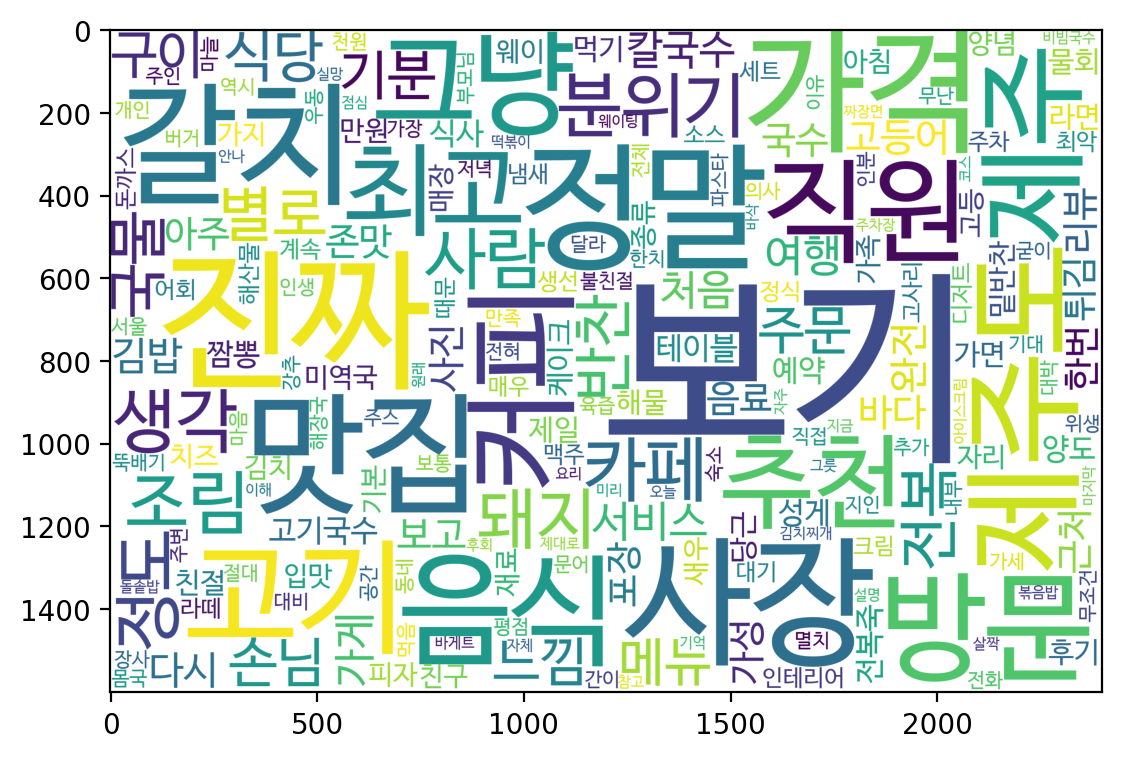

In [33]:
# 워드 클라우드 생성
wc = WordCloud(font_path='NanumBarunGothic', width=1200, height=800, scale=2.0, background_color='white', max_font_size=250)
gen = wc.generate_from_frequencies(word_count)
plt.figure()
plt.imshow(gen)

In [34]:
# 워드 클라우드 저장
wc.to_file('interim_data/review_wordcloud.png')

## train/test 데이터셋 분리

In [35]:
# label이 0~1인 건 train, nan인 건 test로 분리
df_train = df[(df['label']==0) | (df['label']==1)]
df_test = df[df['label'].isnull()]

In [36]:
df_train.to_csv('interim_data/train.csv', header=True, index=False)
df_test.to_csv('interim_data/test.csv', header=True, index=False)

## train 데이터셋 학습

#### KoBERT 입력 데이터 전처리

In [37]:
train = pd.read_csv('interim_data/train.csv')

In [38]:
data_list = []
for review, label in zip(train['reviews'], train['label'])  :
    data = []
    data.append(review)
    data.append(label)

    data_list.append(data)

In [39]:
print(data_list[1])
print(data_list[10])
print(data_list[100])
print(data_list[1000])
print(data_list[10000])

['맛은 잘모르겠고 가격이 너무비쌈 그리고 가장 중요한 직원들이 개판임 너무불친절함 항상 짜증과 표정이 썩어있음 별로', 0.0]
['냉동실에 오래 놔둔 우유아이스크림 먹는맛.. 오늘만 그런건진 모르겠는데 옥수수, 우유 아이스크림 두개에 10500원에 먹었는데 서주아이스주 사먹는게 훳 맛날거 같아요...', 0.0]
['제가 먹어본 함박스테이크중에 제일 맛있었어요..\n사장님도 음식 나올때마다 정성스럽게 가져다 주시고\n너무 좋아요..', 1.0]
['가파도에 맛집이 없나보다.\n불친절은 덤', 0.0]
['레드락이랑 조합 장난아니에요\n화이타 핵 맛집', 1.0]


In [40]:
# train/val 분리
dataset_train, dataset_val = train_test_split(data_list, test_size=0.25, random_state=14)

In [41]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [42]:
# 토큰화, 패딩 실행 함수 정의
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
                    bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair
                    )

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [43]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [44]:
# 토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_val = BERTDataset(dataset_val, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [45]:
# 토큰화 확인
data_train[0]

(array([   2, 4155, 6925, 7295, 6896, 1801, 6133, 5451, 7120, 5152, 5330,
         517, 6750, 6750, 7788, 1967, 7141, 6885, 6855, 6916,  517, 5330,
        5400, 5859, 4483, 5415, 7788, 4204, 5702, 6916,    3,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(31, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [46]:
# torch 형식의 데이터셋 생성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### KoBERT 모델 생성

In [47]:
# 긍정/부정 이진분류 모델
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size=768,
                 num_classes=2,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [48]:
# BERT 모델 불러오기
device = torch.device('cuda')
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [49]:
# optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [50]:
# 정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

#### KoBERT 모델 학습

In [51]:
for e in range(num_epochs):
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        val_acc += calc_accuracy(out, label)
    print("epoch {} validation acc {}".format(e+1, val_acc / (batch_id+1)))

<ipython-input-51-b776dfad00e9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7332449555397034 train acc 0.484375
epoch 1 batch id 201 loss 0.20410959422588348 train acc 0.8467039800995025
epoch 1 train acc 0.8822527258566978


<ipython-input-51-b776dfad00e9>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/107 [00:00<?, ?it/s]

epoch 1 validation acc 0.9536604361370717


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.1655079424381256 train acc 0.96875
epoch 2 batch id 201 loss 0.11693337559700012 train acc 0.9562344527363185
epoch 2 train acc 0.9633956386292835


  0%|          | 0/107 [00:00<?, ?it/s]

epoch 2 validation acc 0.958820093457944


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.11830514669418335 train acc 0.953125
epoch 3 batch id 201 loss 0.09598174691200256 train acc 0.978467039800995
epoch 3 train acc 0.981113707165109


  0%|          | 0/107 [00:00<?, ?it/s]

epoch 3 validation acc 0.9583333333333334


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.09133516997098923 train acc 0.96875
epoch 4 batch id 201 loss 0.0028971857391297817 train acc 0.9916822139303483
epoch 4 train acc 0.9930880062305296


  0%|          | 0/107 [00:00<?, ?it/s]

epoch 4 validation acc 0.965440031152648


  0%|          | 0/321 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.010838635265827179 train acc 1.0
epoch 5 batch id 201 loss 0.0009464398608542979 train acc 0.9972792288557214
epoch 5 train acc 0.997566199376947


  0%|          | 0/107 [00:00<?, ?it/s]

epoch 5 validation acc 0.9657320872274143


In [52]:
# 해당 모델 피클링
with open('interim_data/kobert_model.pkl','wb') as pickle_file:
    pickle.dump(model, pickle_file)

## test 데이터셋 label 예측

In [53]:
test = pd.read_csv('interim_data/test.csv')

In [54]:
# label 예측 함수 정의
def predict(test_sentence):

    data = [test_sentence, 0]
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length = valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_result = []
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            test_result.append(np.argmax(logits))
      
    return test_result

In [55]:
# test 데이터의 label 예측
for idx, review in enumerate(test['reviews']):
  label_pred = predict(review)
  test.loc[idx, 'label'] = label_pred[0]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [56]:
# label 예측 파일 저장
test.to_csv('interim_data/test_pred.csv', header=True, index=False)

In [57]:
test.head()

,id,rating,reviews,label
0,우유부단;ㅎ;2022.04.16,3.0,"우유아이스크림과 밀크쉐이크, 우도땅콩밀크티는 먹을만한데요 아메리카노,라떼, 카카오밀...",1.0
1,우유부단;BEARDOOR;2022.01.05,3.0,이시돌목장 우유를 좋아해서 밀크티도 기대했는데 조금 아쉬웠네요...그래도 목장 구경...,0.0
2,우유부단;유 동호;2021.10.31,3.0,우유의 고소함이 진해서 맛있지만 너무 비싸요. 주변 볼거리도 딱히 없어요. 폴바셋이...,0.0
3,우유부단;양슐랭;2021.07.27,4.0,1. 맛\n- 우유맛이 진한 우유와 아이스크림\n2. 가격\n- 저렴하지는 않음\n...,0.0
4,우유부단;ㅇㅇ;2021.07.18,4.0,완전 맛있어요! 근데 화장실이 협소하고 더러워요ㅜ,0.0


In [58]:
test['label'].mean()

0.7149371456741435

In [59]:
test[test['rating']==3]['label'].mean()

0.42163661581137307

In [60]:
test[test['rating']==4]['label'].mean()

0.8766730401529637

Text(0.5, 1.0, 'Label prediction of the rating 3~4')

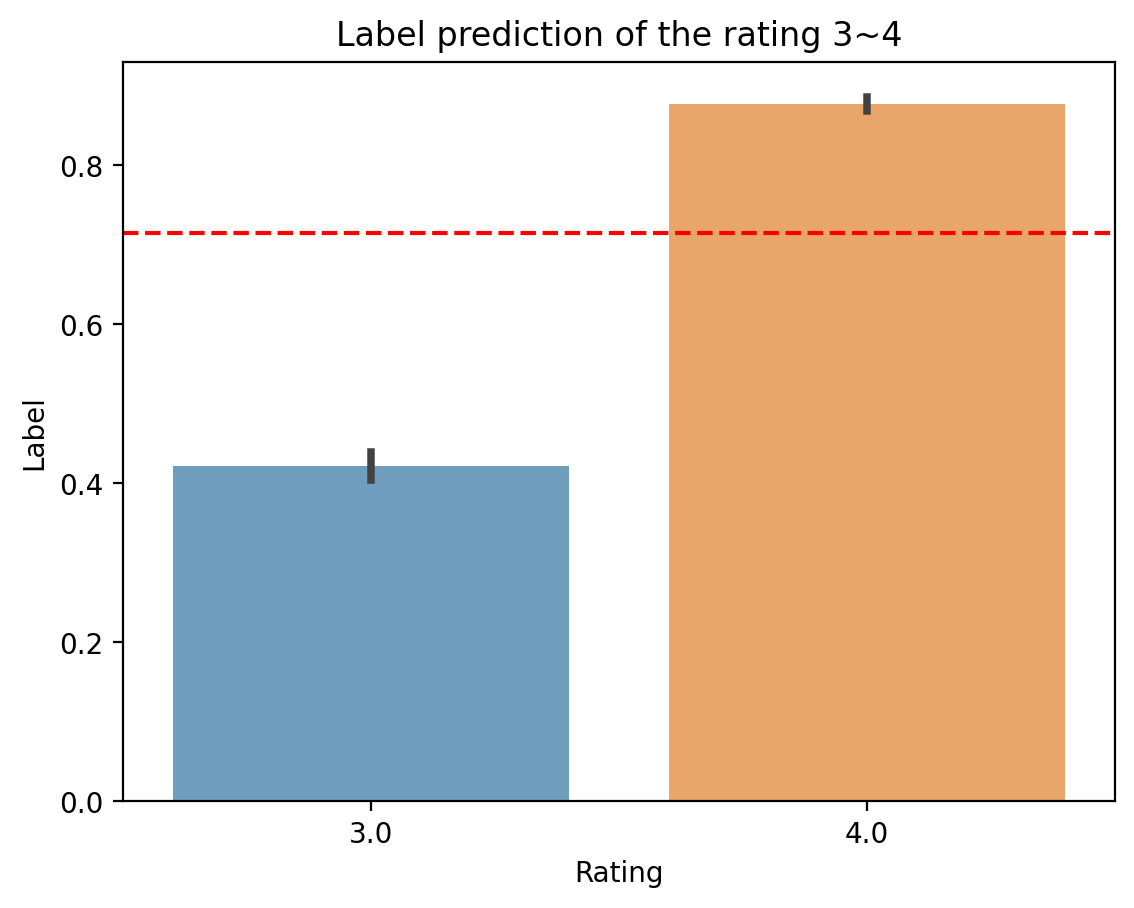

In [61]:
# rating별 label 확인
test_mean = test['label'].mean()
sns.barplot(data=test, x='rating', y='label', alpha=0.7)
plt.axhline(y=test_mean, color='r', ls='--')
plt.xlabel('Rating')
plt.ylabel('Label')
plt.title('Label prediction of the rating 3~4')

Text(0.5, 1.0, 'Label prediction on label=0.5')

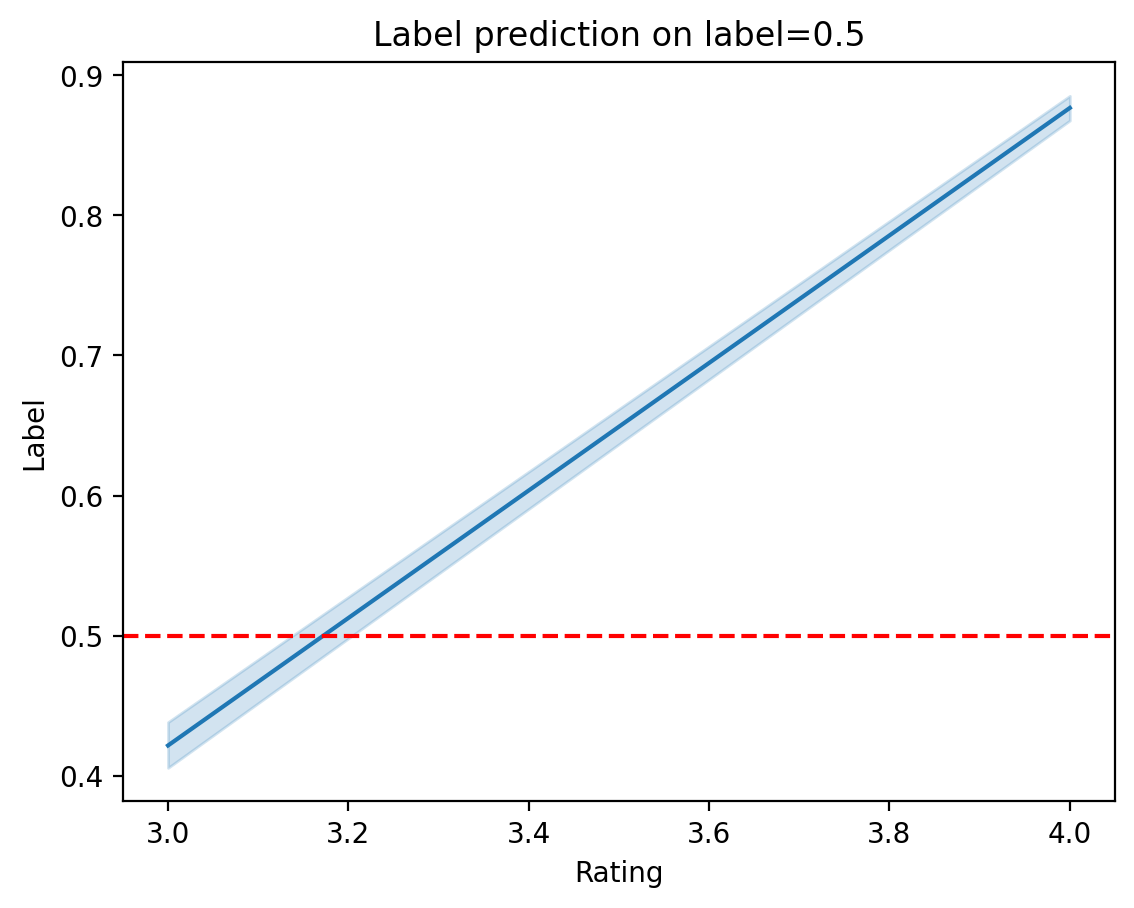

In [62]:
# label이 0.5인 경우의 rating 확인
sns.lineplot(data=test, x='rating', y='label')
plt.axhline(y=0.5, color='r', ls='--')
plt.xlabel('Rating')
plt.ylabel('Label')
plt.title('Label prediction on label=0.5')